In [1]:
import pandas as pd
import numpy as np

#For Plotting 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid')
import plotly.express as px

# For preprocess1

import re
import string

# For NLP Models and stopword removal

import nltk
from nltk import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
plt.figure(figsize=(20,30))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


<Figure size 1440x2160 with 0 Axes>

<Figure size 1440x2160 with 0 Axes>

# __Importing data__

In [2]:
data = pd.read_csv('twitter_training.csv', names=['s_no','topic','sentiment','text'])
data = data.drop(columns='s_no')
data.head(10)

,topic,sentiment,text
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,Borderlands,Positive,im getting into borderlands and i can murder y...
6,Borderlands,Positive,So I spent a few hours making something for fu...
7,Borderlands,Positive,So I spent a couple of hours doing something f...
8,Borderlands,Positive,So I spent a few hours doing something for fun...
9,Borderlands,Positive,So I spent a few hours making something for fu...


In [3]:
data.shape

(74682, 3)

In [4]:
# sns.set_style('ticks')
# fig, ax = plt.subplots()
# # the size of A4 paper
# fig.set_size_inches(40, 8.27)
# sns.countplot(data['topic'], data=data, ax=ax)    
# sns.despine()

In [5]:
#px.bar(data, x=data['topic'], color=data['topic'])

# __Handling duplicates and null values__

### ___removing duplicate records___

In [6]:
print(f'Dataframe Shape     : {data.shape}')
print(f'Duplcate Records    : {data.duplicated().sum()}')

Dataframe Shape     : (74682, 3)
Duplcate Records    : 3621


In [7]:
data.drop_duplicates(inplace=True)

print(f'Dataframe Shape     : {data.shape}')
print(f'Duplcate Records    : {data.duplicated().sum()}')

Dataframe Shape     : (71061, 3)
Duplcate Records    : 0


### ___removing null values___

In [8]:
data.isna().sum()

topic          0
sentiment      0
text         103
dtype: int64

In [9]:
data.iloc[np.where(data.isna() == True)[0]]['sentiment'].value_counts()

Negative      31
Positive      28
Neutral       27
Irrelevant    17
Name: sentiment, dtype: int64

In [10]:
data = data.dropna()
data.isna().sum()

topic        0
sentiment    0
text         0
dtype: int64

# __EDA__

<AxesSubplot:xlabel='sentiment', ylabel='count'>

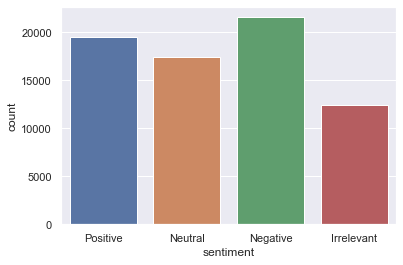

In [11]:
sns.countplot(x='sentiment', data=data)

In [12]:
data['sentiment'].value_counts(normalize=False)

Negative      21565
Positive      19549
Neutral       17398
Irrelevant    12446
Name: sentiment, dtype: int64

In [13]:
data['sentiment'] = data['sentiment'].map({'Irrelevant':1, 'Neutral':1, 'Positive':2, 'Negative':0})

In [14]:
labels = ['Negative', 'Neutral', 'Positive']
data['sentiment'].value_counts(normalize=False)

1    29844
0    21565
2    19549
Name: sentiment, dtype: int64

In [15]:
px.bar(data.groupby(by='sentiment').size().reset_index(), x=['Negative', 'Neutral', 'Positive'], y=0, color=labels, color_discrete_sequence=px.colors.qualitative.Antique)

#dir(px.colors.qualitative) for all color palettes

In [16]:
data.sample(10)

,topic,sentiment,text
17784,PlayStation5(PS5),2,Ah cool...
35324,Microsoft,1,Microsoft RCE vulnerabilities affecting Window...
17750,PlayStation5(PS5),1,"Join us this weekend as we discuss the PS5, li..."
31679,LeagueOfLegends,0,Easy Mental Games!..
44118,PlayerUnknownsBattlegrounds(PUBG),0,"Indian Army to delete 89 apps including FB ,Ti..."
23113,CS-GO,1,"I probably won't play much, if anything, but I..."
56029,TomClancysRainbowSix,1,We are sorry that there is no live stream toni...
23851,Google,0,Netflix is the new Google. Products kill the w...
55691,CallOfDuty,1,My man is still waiting for me.
46180,Verizon,2,Support small businesses members and


In [17]:
data.groupby(by='topic').get_group('Google')['sentiment'].value_counts()

1    1280
0     569
2     339
Name: sentiment, dtype: int64

# __Pre-Processing__

#### ___Pre-Processing 1: Removing html, numbers, punctuation and lower casing the messages___

In [18]:
import re
import string

def preprocess1(text):
    # removing \n
    text = re.sub(r'[\n]',' ',text) 
    # removing HTML Tags
    text = re.sub(r'<.*?>',' ',text)
    # removing URLs
    text = re.sub(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|text|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|text|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""", '',text)
    # removing numbers and punctations
    text = re.sub(r'[^a-zA-Z]',' ',text)
    # removing individual stray alphabets
    text = re.sub(r'\b[a-zA-Z]\b','', text)
    # lower casing 
    text = text.lower()
    
    return text

In [19]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [20]:
print(u"nadlf \U0001F600 and nadkada")
print(remove_emoji(u"nadlf \U0001F600 and nadkada"))

nadlf 😀 and nadkada
nadlf  and nadkada


In [21]:
print(data['text'][0],'\n')
print(data['text'][274],'\n')
print(data['text'][7465],'\n')

im getting on borderlands and i will murder you all , 

bl3 using girl on fire for writing the end credits It is probably why i r ’ m gonna quit borderlands forever 

smashed some Overwatch, then hit the Beat Saber on the VR and cooled off with @ flames79t on Paladins. Thank you @ RoseUKFam for the great host < 3 @ DadGamerOfTwo for giving Rose a sub, @ Stark1z for the diamond, all of the following and all < 3 78 to the 3k hair dye stream!! 



In [22]:
data['tweet_cleaned'] = data['text'].apply(preprocess1)

In [23]:
print('Some tweets after cleaning:')
print('-------------------------------------------------------------------------------------------------------------------------------------------')
print(data['tweet_cleaned'][0],'\n')
print(data['tweet_cleaned'][274],'\n')
print(data['tweet_cleaned'][7465],'\n')

Some tweets after cleaning:
-------------------------------------------------------------------------------------------------------------------------------------------
im getting on borderlands and  will murder you all   

bl  using girl on fire for writing the end credits it is probably why      gonna quit borderlands forever 

smashed some overwatch  then hit the beat saber on the vr and cooled off with   flames   on paladins  thank you   roseukfam for the great host       dadgameroftwo for giving rose  sub    stark  for the diamond  all of the following and all        to the   hair dye stream   



### ___Pre-Processing 2: Removing stop words and performing lemmatization/stemming___

In [24]:
ps = PorterStemmer()
lm = WordNetLemmatizer()

stop_words = stopwords.words('english')

def preprocess2(text, flg_stemm=False, flg_lemm=True):
    # Tokenization
    tokens = text.split()

    # Stemming implementation
    if flg_stemm == True:
        text = [ps.stem(word) for word in tokens if word not in stop_words]

    # Lemmatization implementation
    if flg_lemm == True:
        text = [lm.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(text)

In [25]:
# from nltk import word_tokenize
# nltk.download('punkt')
# token = word_tokenize(data['tweet_cleaned'][0])

In [26]:
data['tweet_stem'] = data['tweet_cleaned'].apply(lambda x: preprocess2(x, flg_stemm=True, flg_lemm=False))
data['tweet_lemm'] = data['tweet_cleaned'].apply(lambda x: preprocess2(x, flg_stemm=False, flg_lemm=True))

In [27]:
print('Some tweets after stemming:')
print('-------------------------------------------------------------------------------------------------------------------------------------------')
print(data['tweet_stem'][0],'\n')
print(data['tweet_stem'][274],'\n')
print(data['tweet_stem'][7465],'\n')

Some tweets after stemming:
-------------------------------------------------------------------------------------------------------------------------------------------
im get borderland murder 

bl use girl fire write end credit probabl gonna quit borderland forev 

smash overwatch hit beat saber vr cool flame paladin thank roseukfam great host dadgameroftwo give rose sub stark diamond follow hair dye stream 



In [28]:
print('Some tweets after lemmatizing:')
print('-------------------------------------------------------------------------------------------------------------------------------------------')
print(data['tweet_lemm'][0],'\n')
print(data['tweet_lemm'][274],'\n')
print(data['tweet_lemm'][7465],'\n')

Some tweets after lemmatizing:
-------------------------------------------------------------------------------------------------------------------------------------------
im getting borderland murder 

bl using girl fire writing end credit probably gonna quit borderland forever 

smashed overwatch hit beat saber vr cooled flame paladin thank roseukfam great host dadgameroftwo giving rose sub stark diamond following hair dye stream 



### ___Some exploration of the stemmed and lemmatized tweets___

#### _Stemmed Tweets_

In [29]:
corpus_stem = []
for sent in data['tweet_stem'].values:
    for word in sent.split():
            corpus_stem.append(word)
print(f'Length of stemmed tweet corpus_stem: {len(corpus_stem)}\n')

from collections import Counter
print(f'10 Most Common Words: ')
for item, value in Counter(corpus_stem).most_common(10):
    print(f'{item}\t{value}')


Length of stemmed tweet corpus_stem: 743384

10 Most Common Words: 
game	12101
play	6890
get	5582
like	5175
fuck	4181
go	4002
love	3762
one	3715
good	3522
time	3349


(-0.5, 2999.5, 1999.5, -0.5)

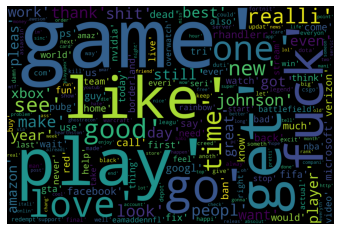

In [30]:
from wordcloud import WordCloud
word_cloud = WordCloud(collocations = False, width=3000, height=2000, background_color = 'black').generate(str(corpus_stem))
plt.imshow(word_cloud)
plt.axis('off')

#### _Lemmatizied Tweets_

In [31]:
corpus_lemm = []
for sent in data['tweet_lemm'].values:
    for word in sent.split():
            corpus_lemm.append(word)
print(f'Length of stemmed tweet corpus_lemm: {len(corpus_lemm)}\n')

from collections import Counter
print(f'10 Most Common Words:')
for item, value in Counter(corpus_lemm).most_common(10):
    print(f'{item}\t{value}')

Length of stemmed tweet corpus_lemm: 743384

10 Most Common Words:
game	11533
like	4916
get	4320
one	3715
play	3592
good	3497
time	3293
love	3237
really	3218
new	3204


(-0.5, 399.5, 199.5, -0.5)

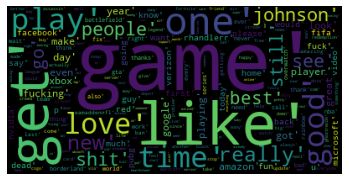

In [32]:
from wordcloud import WordCloud
word_cloud = WordCloud(collocations = False, background_color = 'black').generate(str(corpus_lemm))
plt.imshow(word_cloud)
plt.axis('off')

In [33]:
#' '.join(data['text']) Join text data from a column in a dataframe

# __Model Building__

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder

tf_idf = TfidfVectorizer()
mnb_lemm = MultinomialNB()
mnb_stem = MultinomialNB()
#le = LabelEncoder()

#data['sentiment'] = le.fit_transform(data['sentiment'])
x_train, x_test, y_train, y_test = train_test_split(data, data['sentiment'], test_size=0.2)

In [35]:
labels = ['Negative', 'Neutral', 'Positive']

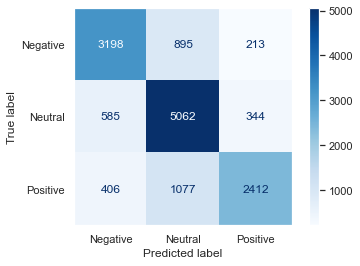

In [40]:
X_train = tf_idf.fit_transform(x_train['tweet_stem']).toarray()
mnb_stem.fit(X_train,y_train)

X_test = tf_idf.transform(x_test['tweet_stem']).toarray()
y_pred = mnb_stem.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)  
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')   
plt.grid(False)
plt.show()

In [38]:
mnb_stem.score(X_test,y_test)

0.7576803833145435

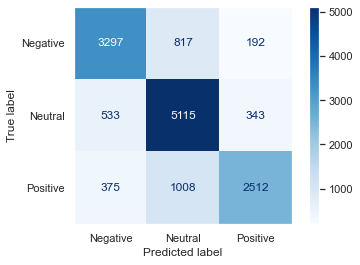

In [41]:
X_train = tf_idf.fit_transform(x_train['tweet_lemm']).toarray()
mnb_lemm.fit(X_train,y_train)

X_test = tf_idf.transform(x_test['tweet_lemm']).toarray()
y_pred = mnb_lemm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)  
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')   
plt.grid(False)
plt.show()

In [43]:
mnb_lemm.score(X_test,y_test)

0.7697294250281849

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77      4306
           1       0.74      0.85      0.79      5991
           2       0.82      0.64      0.72      3895

    accuracy                           0.77     14192
   macro avg       0.78      0.75      0.76     14192
weighted avg       0.78      0.77      0.77     14192



# __Importing val dataset__

In [45]:
df_val = pd.read_csv('twitter_validation.csv', names=['s_no','topic','sentiment','text'])
df_val = df_val.drop(columns='s_no')

df_val['sentiment'] = df_val['sentiment'].map({'Irrelevant':1, 'Neutral':1, 'Positive':2, 'Negative':0})

df_val['tweet_cleaned'] = df_val['text'].apply(preprocess1)
df_val['tweet_stem'] = df_val['tweet_cleaned'].apply(lambda x: preprocess2(x, flg_stemm=True, flg_lemm=False))
df_val['tweet_lemm'] = df_val['tweet_cleaned'].apply(lambda x: preprocess2(x, flg_stemm=False, flg_lemm=True))

In [46]:
df_val.head(2)

,topic,sentiment,text,tweet_cleaned,tweet_stem,tweet_lemm
0,Facebook,1,I mentioned on Facebook that I was struggling ...,mentioned on facebook that was struggling fo...,mention facebook struggl motiv go run day tran...,mentioned facebook struggling motivation go ru...
1,Amazon,1,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezos rejects clai...,bbc news amazon boss jeff bezo reject claim co...,bbc news amazon bos jeff bezos reject claim co...


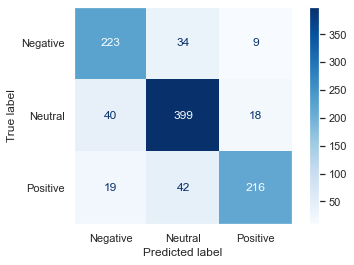

In [47]:
x_val = tf_idf.transform(df_val['tweet_lemm']).toarray()
y_pred = mnb_lemm.predict(x_val)

cm = confusion_matrix(df_val['sentiment'], y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)  
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')   
plt.grid(False)
plt.show()

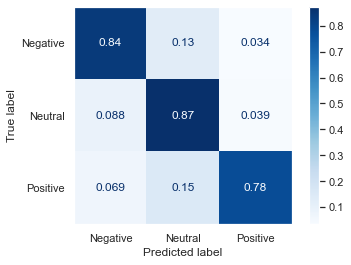

In [53]:
cm = confusion_matrix(df_val['sentiment'], y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=labels)  
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')   
plt.grid(False)
plt.show()

In [48]:
mnb_lemm.score(x_val,df_val['sentiment'])

0.838